## 8-7. 프로젝트: 한영 번역기 만들기
#### 라이브러리 버전을 확인해 봅니다

사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import pandas
import tensorflow
import matplotlib

print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

1.3.3
2.6.0
3.4.3


#### Step 1. 데이터 다운로드
아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

* [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time,copy
import re
import os
import io

print(tf.__version__)

2.6.0


In [3]:
path = r'/aiffel/aiffel/s2s_translation/kor_eng'
url = 'https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    path + r'/korean-english-park.train.tar.gz',
    origin= url,
    extract=True, cache_subdir='data', cache_dir= path )
    
print(path_to_zip)


/aiffel/aiffel/s2s_translation/kor_eng/korean-english-park.train.tar.gz


In [4]:
path_to_file_kor = os.path.dirname(path_to_zip)+ '/data/korean-english-park.train.ko'
print(path_to_file_kor)
path_to_file_eng = os.path.dirname(path_to_zip)+ '/data/korean-english-park.train.en'
print(path_to_file_eng)

with open(path_to_file_kor, "r") as f:    
    raw_kor = f.read().splitlines()
    
with open(path_to_file_eng, "r") as f:    
    raw_eng = f.read().splitlines()
    
print("kor Data Size:", len(raw_kor), "eng Data Size:", len(raw_eng))   #94123,  94123

print("kor_Example:")
for sen in raw_kor[0:100][::20]: print(">>", sen)
print("eng_Example:")
for sen in raw_eng[0:100][::20]: print(">>", sen) 
    
    
print("kor_Example2:")
for sen in raw_kor[99:101]: print(">>", sen)
print("eng_Example2:")
for sen in raw_eng[99:101]: print(">>", sen)    

/aiffel/aiffel/s2s_translation/kor_eng/data/korean-english-park.train.ko
/aiffel/aiffel/s2s_translation/kor_eng/data/korean-english-park.train.en
kor Data Size: 94123 eng Data Size: 94123
kor_Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
eng_Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on

#### Step 2. 데이터 정제
set 데이터형이 **중복을 허용하지 않는다는 것을 활용**해 중복된 데이터를 제거하도록 합니다. 데이터의 **병렬 쌍이 흐트러지지 않게 주의**하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. **한글에 적용할 수 있는 정규식**을 추가하여 함수를 재정의하세요!

타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 **KoNLPy** 의 mecab 클래스를 사용합니다.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 **토큰의 길이가 40 이하인 데이터를 선별**하여 eng_corpus와 kor_corpus를 각각 구축하세요.

#### raw_kor, raw_eng 를 set 및 zip을 활용하여, 병렬 쌍이 흐트러지지 않게해서  중복제거후,  cleaned_corpus 에 저장

In [5]:
## 데이터 정제 및 토큰화
assert len(raw_kor) == len(raw_eng)
print(len(raw_kor), len(raw_eng))    
cleaned_corpus = list(set(zip(raw_kor,raw_eng)))

# 문장별로 튜플을 풀어서 str 로 전환: 한개의 문장내 한글 vs 영어는 공백4칸으로 구분, 문장별 구분은 '\n'으로 구분
cleaned_corpus = [line[0] + ' '*4 + line[1] +'\n' for line in cleaned_corpus]
print("cleaned_corpus",cleaned_corpus[:2], len(cleaned_corpus))

# 저장
with open(os.path.dirname(path_to_zip)+ '/cleaned_corpus/kor_eng_pairs.txt', 'w') as f:  
        for line in cleaned_corpus:
            f.write(line)
            
# 저장여부 확인
with open(os.path.dirname(path_to_zip)+ '/cleaned_corpus/kor_eng_pairs.txt', "r") as f:    
    cleaned_corpus_check = f.read().splitlines()    # \n 떼어 놓고, line별 구분됨 
    
print("저장된 cleaned_corpus 로드후 확인: ", cleaned_corpus_check[:2])
print("중복제거후 문장개수: ", len(cleaned_corpus))                

94123 94123
cleaned_corpus ['버지니아 공대 4학년 학생인 셰인 무어는 17일(현지시간) 조와 3년 전 점심을 같이 먹은 적이 있다고 말했다.    Virginia Tech senior Shane Moore said Tuesday he recalled having lunch with Cho three years ago.\n', '#47484 보여주어야 한다고 말했다. 특히 그는 북한이 ""슈퍼노트를 제조할 수 있는 장비와 동판을 제거했다는 증거를 제시해야 앞으로 지폐를 제작할 수 있는 능력이 있다는 염려가 줄어들 것이다""라고 말했다.    Specifically, he said, the North must ""provide evidence that the equipment and plates for the so-called supernotes had been destroyed so that concerns about further ability [to print more notes] will be reduced.\n'] 78968
저장된 cleaned_corpus 로드후 확인:  ['버지니아 공대 4학년 학생인 셰인 무어는 17일(현지시간) 조와 3년 전 점심을 같이 먹은 적이 있다고 말했다.    Virginia Tech senior Shane Moore said Tuesday he recalled having lunch with Cho three years ago.', '#47484 보여주어야 한다고 말했다. 특히 그는 북한이 ""슈퍼노트를 제조할 수 있는 장비와 동판을 제거했다는 증거를 제시해야 앞으로 지폐를 제작할 수 있는 능력이 있다는 염려가 줄어들 것이다""라고 말했다.    Specifically, he said, the North must ""provide evidence that the equipment and plates for the so-called supernotes had been destroyed so that

In [6]:
## 중복여부 다시 체크: DataFrame Duplicate로 체크

print("중복제거이전 총문장개수:",len(cleaned_corpus))

# 중복제거위해 DataFrame만들기:  
df_pairs = pd.DataFrame({'cleaned_corpus': cleaned_corpus}) 
print(df_pairs.shape, df_pairs[:5])

# 중복 문장개수 체크
print("중복문장개수:",df_pairs.duplicated().sum())
print(df_pairs[df_pairs.duplicated()==True])

# 중복제거
df_pairs_clean = df_pairs.drop_duplicates()

print("중복제거이후 Unique 문장개수:",len(df_pairs_clean))
print("중복제거 비율 %", round((len(df_pairs)-len(df_pairs_clean))*100/len(df_pairs),2))


중복제거이전 총문장개수: 78968
(78968, 1)                                       cleaned_corpus
0  버지니아 공대 4학년 학생인 셰인 무어는 17일(현지시간) 조와 3년 전 점심을 같...
1  #47484 보여주어야 한다고 말했다. 특히 그는 북한이 ""슈퍼노트를 제조할 수 ...
2  최근 FARC로부터 석방된 한 피랍자는 베탕쿠르의 건강이 매우 악화됐다고 진술했으며...
3  식품의약품안전청은 양식 민물고기에서 위험 수위에 이르는 발암 물질이 검출되었다는 해...
4  폭스 뉴스가 입수한 법원 문서에 의하면 잭슨이 경매 등록일인 내달 19일까지 빚을 ...
중복문장개수: 0
Empty DataFrame
Columns: [cleaned_corpus]
Index: []
중복제거이후 Unique 문장개수: 78968
중복제거 비율 % 0.0


#### preprocess_sentence 함수를 한글도 처리가능케 재정의

In [7]:
def preprocess_sentence(sentence, kor_token=False, eng_token=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^0-9ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()

    if kor_token:
        sentence = '<BOS> ' + sentence
    if eng_token:
        sentence += ' <EOS>'
    
    return sentence


#### 문장을 단어단위 토큰화 단어수 40개미만 문장만 선별

* 1.**한글 형태소분석기로 kor 단어토큰화 및 불용어제거 : enc_corpus**

* 2.**영어는 공백에의해 단어 split됨: enc_corpus**

* 3.**긴문장 과다에의한 학습시간 과다소요 방지위해서, 한글 단어수 40개이상 및 영어단어수 45개이상의 문장은 제거하고, 각각40개,45개 미만 문장만 선별: 문장수 78,968개 ==> 76,536개로 축소 >>> 한글 단어 39개 문장에 매치되는 영어단어수 91개임**

####  preprocess 및 형태소 분석 : kor_corpus, eng_corpus 분리해서 데이터 preprocess 및 형태소 분석으로 단어추출 토큰화  

In [8]:
from konlpy.tag import Mecab 

tokenizer = Mecab()

# 형태소 분석, 토큰화(tokenization)
kor_text_data = []
eng_text_data = []

# 샘플수 제한할 경우 
num_examples = 30000  # len(cleaned_corpus)78968 

for i, pair in enumerate(cleaned_corpus[:num_examples]):
    kor_temp_data = []
    eng_temp_data = []
    # pair 분리
    kor_sentence = pair.split(' '*4)[0]
    eng_sentence = pair.split(' '*4)[1]
    #print("kor_sentence",kor_sentence, "eng_sentence",eng_sentence)
    
    # preprocess: 데이터 정제화
    kor_sentence = preprocess_sentence(kor_sentence)
    eng_sentence  = preprocess_sentence(eng_sentence, kor_token=True, eng_token=True)
    
    # 토큰화
    kor_temp_data = tokenizer.morphs(kor_sentence) 
    eng_temp_data = eng_sentence.split(' ')
    
    # append
    kor_text_data.append(kor_temp_data)
    eng_text_data.append(eng_temp_data)
               
    if i <= 1 or i%10000==0:
        print("i",i, kor_text_data[-1],len(kor_text_data[-1]), eng_text_data[-1], len(eng_text_data[-1]))
    if i==len(cleaned_corpus)-1:
        print("End_i", i)
    
print("kor_text_data",kor_text_data[:5], len(kor_text_data))   # 40037
print("eng_text_data",eng_text_data[:5], len(eng_text_data))   # 40037


# enc_text_data 를  enc_corpus로, dec_text_data 를  dec_corpus로명칭 복원
kor_corpus = kor_text_data.copy()
eng_corpus = eng_text_data.copy()

print("kor_corpus 길이: ", len(kor_corpus))
print("eng_corpus 길이: ", len(eng_corpus))


i 0 ['버지니아', '공대', '4', '학년', '학생', '인', '셰', '인', '무어', '는', '17', '일', '현지', '시간', '조', '와', '3', '년', '전', '점심', '을', '같이', '먹', '은', '적', '이', '있', '다고', '말', '했', '다', '.'] 32 ['<BOS>', 'virginia', 'tech', 'senior', 'shane', 'moore', 'said', 'tuesday', 'he', 'recalled', 'having', 'lunch', 'with', 'cho', 'three', 'years', 'ago', '.', '<EOS>'] 19
i 1 ['47484', '보여', '주', '어야', '한다고', '말', '했', '다', '.', '특히', '그', '는', '북한', '이', '슈퍼', '노트', '를', '제조', '할', '수', '있', '는', '장비', '와', '동판', '을', '제거', '했', '다는', '증거', '를', '제시', '해야', '앞', '으로', '지폐', '를', '제작', '할', '수', '있', '는', '능력', '이', '있', '다는', '염려', '가', '줄어들', '것', '이', '다', '라고', '말', '했', '다', '.'] 57 ['<BOS>', 'specifically', ',', 'he', 'said', ',', 'the', 'north', 'must', 'provide', 'evidence', 'that', 'the', 'equipment', 'and', 'plates', 'for', 'the', 'so', 'called', 'supernotes', 'had', 'been', 'destroyed', 'so', 'that', 'concerns', 'about', 'further', 'ability', 'to', 'print', 'more', 'notes', 'will', 'be', 'reduced'

#### Step 3. 데이터 토큰화
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다. ===> 분리

#### 정수인덱스 토큰화하기, 보정처리 및 padding:  40단어 이하 문장만 선택

In [9]:
#### 정수인덱스 토큰화하기, 보정처리 및 padding
def tokenize(corpus, maxlen= 39, kor = False): 
    ## 정수인덱스 토큰화
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',lower = False, oov_token= '<UNK>')  #lower 또하면 'BOS''EOS'도 소문자됨      
    tokenizer.fit_on_texts(corpus)
    #[주의!!] 보정처리할 경우에는 texts_to_sequences(corpus)를 보정처리후 padding전에  해야함
    #tensor = tokenizer.texts_to_sequences(corpus)
    
       
    ## 보정처리, texts_to_sequences 및 패딩: 
    print("보정전 단어사전 길이:", len(tokenizer.index_word), len(tokenizer.word_index))
    if kor == True:
        # 한글 보정처리
        print("보정전 tokenizer.index_word[0~10]",[(k,v) for (k,v) in tokenizer.index_word.items() if k <=10])
        
        tokenizer.index_word = {k + 3: v for k,v in tokenizer.index_word.items()}
        tokenizer.index_word.update({0:'<PAD>',1:'', 2:'', 3:'<UNK>'}) 
        del tokenizer.index_word[1]  # 1 공백제거 
        del tokenizer.index_word[2]  # 2 공백제거
        del tokenizer.index_word[4]  # 4 중복된 'UNK' 제거
        tokenizer.word_index = {v: k for k,v in tokenizer.index_word.items()}
        print("tokenizer.index_word",tokenizer.index_word[0],tokenizer.index_word[3],tokenizer.index_word[5])
        print("tokenizer.word_index",tokenizer.word_index['<PAD>'],tokenizer.word_index['<UNK>'])
        print("보정후 tokenizer.index_word[0~10]",[(k,v) for i,(k,v) in enumerate(tokenizer.index_word.items()) if i <=10])
        
        # 보정처리완료후texts_to_sequences(corpus)
        tensor = tokenizer.texts_to_sequences(corpus)
        # 패딩
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen = maxlen, padding='post') #maxlen = 50,
    else:
        # 영어 보정처리
        print("보정전 tokenizer.index_word[0~10]",[(k,v) for i,(k,v) in enumerate(tokenizer.index_word.items()) if i <=10])
        
        tokenizer.index_word = {k + 3: v for k,v in tokenizer.index_word.items()}
        tokenizer.index_word.update({0:'<PAD>',1: '<BOS>', 2:'<EOS>', 3:'<UNK>'}) 
        del tokenizer.index_word[4]  # 4 중복된 'UNK' 제거
        del tokenizer.index_word[7]  # 7 중복된 'BOS' 제거
        del tokenizer.index_word[8]  # 8 중복된 'EOS' 제거
        tokenizer.word_index = {v: k for k,v in tokenizer.index_word.items()}
        print("tokenizer.index_word",tokenizer.index_word[0],tokenizer.index_word[1],tokenizer.index_word[2],
             tokenizer.index_word[3],tokenizer.index_word[5])
        print("tokenizer.word_index",tokenizer.word_index['<PAD>'],tokenizer.word_index['<BOS>'],
              tokenizer.word_index['<EOS>'],tokenizer.word_index['<UNK>'])    
        print("보정후 tokenizer.index_word[0~10]",[(k,v) for (k,v) in tokenizer.index_word.items() if k <=10])
        
        # 보정처리완료후texts_to_sequences(corpus)
        tensor = tokenizer.texts_to_sequences(corpus)
        # 패딩
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen = maxlen, padding='post') #maxlen = 50,
        
    
    print("보정후 단어사전 길이:", len(tokenizer.index_word), len(tokenizer.word_index))
    
    return tensor, tokenizer


kor_max 127


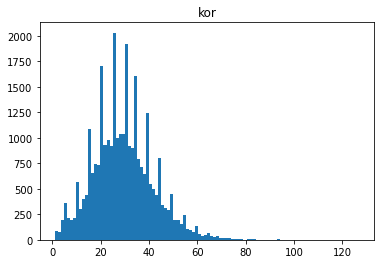

eng_max 91


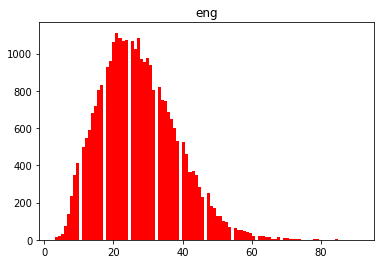

kor [['버지니아', '공대', '4', '학년', '학생', '인', '셰', '인', '무어', '는', '17', '일', '현지', '시간', '조', '와', '3', '년', '전', '점심', '을', '같이', '먹', '은', '적', '이', '있', '다고', '말', '했', '다', '.'], ['47484', '보여', '주', '어야', '한다고', '말', '했', '다', '.', '특히', '그', '는', '북한', '이', '슈퍼', '노트', '를', '제조', '할', '수', '있', '는', '장비', '와', '동판', '을', '제거', '했', '다는', '증거', '를', '제시', '해야', '앞', '으로', '지폐', '를', '제작', '할', '수', '있', '는', '능력', '이', '있', '다는', '염려', '가', '줄어들', '것', '이', '다', '라고', '말', '했', '다', '.'], ['최근', 'farc', '로부터', '석방', '된', '한', '피랍', '자', '는', '베탕쿠르', '의', '건강', '이', '매우', '악화', '됐', '다고', '진술', '했으며', '일부', '언론', '은', '그', '가', '피랍', '된', '지', '6', '주년', '이', '되', '는', '지난', '2', '월', '23', '일', '부터', '단식', '투쟁', '을', '시작', '했', '다고', '보도', '했', '다', '.']]
eng [['<BOS>', 'virginia', 'tech', 'senior', 'shane', 'moore', 'said', 'tuesday', 'he', 'recalled', 'having', 'lunch', 'with', 'cho', 'three', 'years', 'ago', '.', '<EOS>'], ['<BOS>', 'specifically', ',', 'he', 'said', ',', 'the', '

In [10]:
## 문장길이별 분포 
korlen = [len(x) for x in kor_corpus]
kor_max= np.max(korlen)
print("kor_max", kor_max)
plt.hist(korlen, bins= 100)
plt.title("kor")
plt.show()

englen = [len(x) for x in eng_corpus]
eng_max= np.max(englen)
print("eng_max", eng_max)
plt.hist(englen, bins= 100, color='red')
plt.title("eng")
plt.show()

## sample
print("kor",kor_corpus[:3])
print("eng",eng_corpus[:3])

In [11]:
## 한단어이하 문장: 한단어짜리라도 번역에는 의미가 있으므로 사용 
lowbins = [x for x in korlen if x <=1]
print(lowbins)
low_sen = [x for x in kor_corpus if len(x) <=1]
print(low_sen)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[['가족'], ['국어사전'], ['과일'], ['영어사전'], ['어휘'], ['영어사전'], ['영어사전'], ['번역'], ['번역'], ['영어사전'], ['국어사전'], ['어휘'], ['어휘'], ['한자사전'], ['산업자원부'], ['영어사전'], ['영어사전'], ['번역'], ['번역'], ['대상포진'], ['어휘'], ['영어사전'], ['번역'], ['영어사전'], ['장소'], ['한자사전'], ['어휘'], ['국어사전'], ['번역'], ['면접'], ['번역'], ['영어사전'], ['어휘'], ['번역'], ['영어사전'], ['원제']]


In [ ]:
#enc_tokenizer

In [12]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 40 이하(영어는 45)인 문장만 남김. 
for idx in tqdm(range(len(kor_corpus))):
    if len(kor_corpus[idx]) < 40 and len(eng_corpus[idx]) < 45 :
        src_corpus.append(kor_corpus[idx])
        tgt_corpus.append(eng_corpus[idx])

print("토큰의 길이가 40미만으로 축소후 src_corpus", len(src_corpus), src_corpus[:2],src_corpus[-2:])
print("토큰의 길이가 45미만으로 축소후 tgt_corpus", len(tgt_corpus), tgt_corpus[:2],tgt_corpus[-2:])

# 정수인덱스 토큰화및 패딩처리를 완료하여 학습용 데이터를 완성. 
enc_train, enc_tokenizer = tokenize(src_corpus, maxlen= 39, kor = True)
dec_train, dec_tokenizer = tokenize(tgt_corpus, maxlen= 44, kor = False)

print("enc_train", len(enc_train), enc_train[:2],enc_train[-2:])
print("dec_train", len(dec_train), dec_train[:2],dec_train[-2:])


  0%|          | 0/30000 [00:00<?, ?it/s]

토큰의 길이가 40미만으로 축소후 src_corpus 23406 [['버지니아', '공대', '4', '학년', '학생', '인', '셰', '인', '무어', '는', '17', '일', '현지', '시간', '조', '와', '3', '년', '전', '점심', '을', '같이', '먹', '은', '적', '이', '있', '다고', '말', '했', '다', '.'], ['폭스', '뉴스', '가', '입수', '한', '법원', '문서', '에', '의하', '면', '잭슨', '이', '경매', '등록', '일', '인', '내달', '19', '일', '까지', '빚', '을', '갚', '지', '않', '으면', '부동산', '이', '경매', '에', '부쳐진다', '.']] [['마이', '스페이스', '는', '지난주', ',', '중남미', '용', '마이', '스페이스', '운영', '을', '시작', '하', '면서', '세계', '로', '시장', '을', '확대', '해', '나가', '고', '있', '다', '.'], ['또한', '자국', '과', '일본', '주둔', '5', '만', '명', '의', '미군', '에', '대한', '방어', '목적', '으로', '도쿄', '는', '2', '개', '의', '미사일', '방어', '시스템', '을', '구입', '하', '기', '로', '결정', '했', '다', '.']]
토큰의 길이가 45미만으로 축소후 tgt_corpus 23406 [['<BOS>', 'virginia', 'tech', 'senior', 'shane', 'moore', 'said', 'tuesday', 'he', 'recalled', 'having', 'lunch', 'with', 'cho', 'three', 'years', 'ago', '.', '<EOS>'], ['<BOS>', 'court', 'documents', 'obtained', 'by', 'fox', 'news', 'warn', 'j

#### train data, valid 분리 
data 전체를 사용하고서, train data 와 valid data를 분리하면, 검증도 할수있고, train data 축소효과도 있어서, data 전체를 사용하고서, train, valid로 분리  


In [13]:
# 8:2 으로 분리
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_train, dec_train, test_size=0.2)

print("enc", enc_train.shape,enc_val.shape)
print("dec", dec_train.shape, dec_val.shape)

print("한글index_word길이:", len(enc_tokenizer.index_word))
print("영어index_word길이:", len(dec_tokenizer.index_word))

print([enc_tokenizer.index_word[i] for i in enc_train[5]])
print([dec_tokenizer.index_word[i] for i in dec_train[5]])

enc (18724, 39) (4682, 39)
dec (18724, 44) (4682, 44)
한글index_word길이: 29780
영어index_word길이: 26918
['러시아', '는', '지난', '29', '일', '신', '형', '다탄두', '대륙', '간', '탄도', '미사일', '을', '시험', '발사', '했으며', '고위', '장성', '들', '은', '이', 'icbm', '이', '향후', '40', '년', '간', '러시아', '의', '안보', '를', '책임질', '것', '이', '라고', '밝혔', '다', '.', '<PAD>']
['<BOS>', 'russia', 'on', 'tuesday', 'test', 'fired', 'a', 'new', 'intercontinental', 'ballistic', 'missile', 'with', 'multiple', 'warheads', 'and', 'a', 'new', 'cruise', 'missiles', ',', 'which', 'russian', 'generals', 'say', 'are', 'sufficient', 'to', 'ensure', 'the', 'country', 's', 'security', 'for', 'the', 'next', '40', 'years', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


#### Step 4. 모델 설계
한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [14]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        #print("attn dense h_enc.shape",h_enc.shape)
        h_dec = tf.expand_dims(h_dec, 1)
        #print("attn  expand h_dec.shape",h_dec.shape)
        h_dec = self.w_dec(h_dec)
        #print("attn dense h_dec.shape",h_dec.shape)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        #print("attn combine tanh score.shape",score.shape)
        
        attn = tf.nn.softmax(score, axis=1)
        #print("attn softmax_score.shape",attn.shape)
        context_vec = attn * h_enc
        #print("attn attn * h_enc==context_vec.shape",context_vec.shape)
        context_vec = tf.reduce_sum(context_vec, axis=1)
        #print("attn reduce_sum axis=1 context_vec.shape",context_vec.shape)
        
        return context_vec, attn


In [15]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, drate):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #, mask_zero=True)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences = True, recurrent_initializer='glorot_uniform')
        self.batchnormal = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(drate)
        
    def call(self, x):
       
        out = self.embedding(x)
        #out = self.batchnormal(out)
        #out = self.dropout(out)
        out = self.gru(out)
        #out = self.batchnormal(out)
        #out = self.dropout(out)
        
        return out
        

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, drate):
        super(Decoder, self).__init__()
       
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #, mask_zero=True)

        self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

        self.gru = tf.keras.layers.GRU(dec_units, return_sequences = True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.batchnormal = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(drate)
        
    def call(self, x, h_dec, enc_out):
        #print("디코더내 input x.shape",x.shape)
       
        context_vec, attn = self.attention(enc_out, h_dec)
        #print("디코더내 context_vec.shape",context_vec.shape, "attn.shape", attn.shape)
        out = self.embedding(x)
        #print("디코더내 emb의 output out.shape",out.shape)
        #out = self.batchnormal(out)
        #out = self.dropout(out)
        #print("디코더내 decoder dropout embedding xoutshape",out.shape)
       
        out = tf.concat([tf.expand_dims(context_vec,1), out], axis = -1)
        #print("디코더내 tf.concat out@@@", out)
        out, h_dec = self.gru(out)
        #out = self.batchnormal(out)
        #out = self.dropout(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)
        
        #print("디코더함수내_ pred", out.shape,out)
        
        return out, h_dec, attn
       


In [27]:
# 코드를 실행하세요.

BATCH_SIZE     =  64  #6432  #512 #64 
SRC_VOCAB_SIZE = 10000 #20000       #len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = 10000 # 20000       #len(dec_tokenizer.index_word) + 1
print(SRC_VOCAB_SIZE,TGT_VOCAB_SIZE)

units         = 1024
embedding_dim = 512
drate = 0.1

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units, drate)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units, drate)

# sample input
sequence_len = 39

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))
print ('sample_state:', sample_state.shape)
sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape, sample_logits[:1])
print ('Decoder Hidden State:', h_dec.shape, h_dec[:1])
print ('Attention:', attn.shape)


10000 10000
Encoder Output: (64, 39, 1024)
sample_state: (64, 1024)
Decoder Output: (64, 10000) tf.Tensor(
[[ 8.5985445e-04  1.2641987e-03 -6.4869778e-07 ...  3.4447538e-04
   5.4878241e-04  1.2374237e-03]], shape=(1, 10000), dtype=float32)
Decoder Hidden State: (64, 1024) tf.Tensor(
[[ 0.00709115  0.00173957  0.0096751  ...  0.01364668  0.01383762
  -0.01832651]], shape=(1, 1024), dtype=float32)
Attention: (64, 39, 1)


#### Step 5. 훈련하기
훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

❕ 참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.
```
## 예문 ##
K1) 오바마는 대통령이다.
K2) 시민들은 도시 속에 산다.
K3) 커피는 필요 없다.
K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
E1) obama is the president . <end>
E2) people are victims of the city . <end>
E2) the price is not enough . <end>
E2) seven people have died . <end>
```

In [28]:
optimizer = tf.keras.optimizers.Adam()  #learning_rate=0.001,
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001) 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
#loss_object = tf.keras.losses.MeanSquaredError()

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)


In [29]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0
    
    #print("train_step f>> src",src.shape)
    #print("train_step f>> tgt",tgt.shape)
    
    
    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        #print("train_step f>>enc_out", enc_out.shape)
        h_dec = enc_out[:, -1]
        #print("train_step f>> h_dec @@@@@@", h_dec.shape) #, h_dec[:3])
        
        dec_src = tf.expand_dims([dec_tok.word_index['<BOS>']] * bsz, 1)  # dec_input= (64,1)
        #print("dec_src@@@",dec_src.shape, dec_src)
        #[주의!!] <start>,<end>처리의 두 방식(for loop vs while):   for loop 를 1부터시작해서,tgt의 <start>제외함, while로 할 경우 <end>나 maxlen에서 멈추게하는데,
        #==> 여기서는 for loop로 처리해서,<end>유무상관없이 maxlen 문장끝에서 멈춤(<end>다음순서에 padding존재,연산이 많아지진 않나??)
        #==> 이러한 for loop 방식을 사용해서, 이 프로젝트에서는 dec_src는 <end>제거, dec_target에는 <start>제거 코드가 없슴
         
        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            #print("pred",pred.shape, pred)
            #print("t",t, "tgt[:, t]", tgt[:, t], "tgt[:, t].shape",tgt[:, t].shape,"@@@","tf.expand_dims(tgt[:, t],axis=1)",tf.expand_dims(tgt[:, t],axis=1))
            
            loss += loss_function(tgt[:, t], pred) #원본
            #loss += loss_function(tf.expand_dims(tgt[:, t],axis=1), pred) #?????????????????????
            
            #print("loss", loss.shape, loss, "tgt.shape", tgt.shape)
            dec_src = tf.expand_dims(tgt[:, t], 1)  # teacher forcing: tgt[:, t]==> real label==> <end>는 padding직전에 존재하게됨 
            #print("dec_src ***",dec_src.shape)
            
    batch_loss = (loss / int(tgt.shape[1]))  # 문장별 총단어토큰별 loss임, batch_size로 나누지 않고, 토큰수로 나눔, batch_size로 나누는 것은
    ##==> 아래 학습 loop 코드내에서, epock 돌때, batch 1개가 끝날때 마다, batch size로 나누어서, 프린트해서 보여줌 !!!!!!!!!!!!!!!!
    #batch_loss = (loss / int(tgt.shape[0])) #my  ==> 여기선 이 코드는 틀림
    
    #print("batch_loss", batch_loss.shape, batch_loss)
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


In [30]:
#checkpoint_dir = 'training_checkpoints'
#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#checkpoint = tf.train.Checkpoint(optimizer=optimizer,  encoder=encoder,  decoder=decoder)

In [31]:
from tqdm import tqdm    # tqdm
import random, time

EPOCHS = 5 #10
stime = time.time()

for epoch in range(EPOCHS):
    epoch_stime = time.time()
    
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        #print("enc_train[idx:idx+BATCH_SIZE]@@@@",enc_train.shape, enc_train[idx:idx+BATCH_SIZE])
        #print("dec_train[idx:idx+BATCH_SIZE]@@@@",dec_train.shape, dec_train[idx:idx+BATCH_SIZE])
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        #print("batch_loss!!!!!!!!!!!", batch_loss, total_loss, total_loss.numpy())
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm
        
    epoch_etime = time.time()
    print("Epoch당_소요시간", (epoch_etime-epoch_stime)/ 60, "분")
    print("현재까지_누적_소요시간", (epoch_etime-stime)/ 60, "분")
    
etime = time.time()
print("최종소요시간", (etime-stime)/ 60, "분")
    

Epoch  1: 100%|██████████| 293/293 [03:13<00:00,  1.51it/s, Loss nan]


Epoch당_소요시간 3.2287479201952616 분
현재까지_누적_소요시간 3.228750228881836 분


Epoch  2: 100%|██████████| 293/293 [02:01<00:00,  2.42it/s, Loss nan]


Epoch당_소요시간 2.0194777051607766 분
현재까지_누적_소요시간 5.248229972521464 분


Epoch  3: 100%|██████████| 293/293 [02:01<00:00,  2.42it/s, Loss nan]


Epoch당_소요시간 2.017473614215851 분
현재까지_누적_소요시간 7.265706904729208 분


Epoch  4: 100%|██████████| 293/293 [02:01<00:00,  2.42it/s, Loss nan]


Epoch당_소요시간 2.0180379152297974 분
현재까지_누적_소요시간 9.283748575051625 분


Epoch  5: 100%|██████████| 293/293 [02:01<00:00,  2.42it/s, Loss nan]

Epoch당_소요시간 2.0185569723447165 분
현재까지_누적_소요시간 11.302308905124665 분
최종소요시간 11.302325475215913 분


0

#### 인코더,디코더 저장: 서브클래싱모델은 HDF5 format으로 저장않됨,케창투2 참조필요, 또는 tf save_weight, 또는 현재코드로 저장해서 나오는 오류볼것

In [32]:
from keras.models import load_model
from keras.utils.vis_utils import model_to_dot

save_path  = '/aiffel/aiffel/s2s_translation/model'

#encoder.save(save_path + '/s2s_encoder_model.h5')
#decoder.save(save_path + '/s2s_decoder_model.h5')

#encoder = load_model('s2s_encoder_model.h5')
#decoder = load_model('s2s_decoder_model.h5')

#model_to_dot(encoder, show_shapes=True)
#model_to_dot(decoder, show_shapes=True)



#### S2S_Attention 번역모델  성능테스트 함수정의

attention.shape (44, 39)
전처리_sentence 커피 한잔부탁해요 .
정수토큰_inputs1_enc_tokenize  [[1901, 3, 5]]
패드_inputs2_pad [[1901    3    5    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
enc_out (1, 39, 1024) tf.Tensor(
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]], shape=(1, 39, 1024), dtype=float32)
dec_hidden (1, 1024) tf.Tensor([[nan nan nan ... nan nan nan]], shape=(1, 1024), dtype=float32)
loop직전 dec_input tf.Tensor([[1]], shape=(1, 1), dtype=int32)
Input: 커피 한잔부탁해요 .
Predicted translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

/tmp/ipykernel_134/2670381119.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_134/2670381119.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


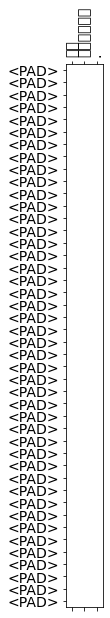

In [92]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    print("attention.shape",attention.shape)
    
    sentence = preprocess_sentence(sentence)
    print("전처리_sentence", sentence)
        
    # 정수 토큰화: 별도로 만든 객체로 해야 정수인덱스 짝이 맞음 
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])   # 별도객체아닌 원문
    print("정수토큰_inputs1_enc_tokenize ",inputs,)
    
    #sentence_word = ' '.join([[enc_tokenizer.index_word[idx] for idx in seq] for seq in inputs][0])
    #print("sentence_word", sentence_word)
    
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=enc_train.shape[-1],padding='post')
    print("패드_inputs2_pad",inputs)
    
    result = ''

    enc_out = encoder(inputs)
    print("enc_out",enc_out.shape, enc_out[:2])
    
    dec_hidden = enc_out[:, -1]
    print("dec_hidden",dec_hidden.shape, dec_hidden[:2])
    
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<BOS>']], 0)
    print("loop직전 dec_input", dec_input)
    
    for t in range(dec_train.shape[-1]):
        #print("t",t)
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        #print("predictions", predictions)
        #print("U attention_weights", attention_weights)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        #print("D attention_weights", attention_weights)
        attention[t] = attention_weights.numpy()
        #print("attention[t]",attention[t])
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()
        #print("predicted_id",predicted_id)
        
        result += dec_tokenizer.index_word[predicted_id] + ' '
        #print("result", result)
        
        if dec_tokenizer.index_word[predicted_id] == '<EOS>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)
        #print("dec_input",dec_input)
        
    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder, plot= False ):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    if plot==True:
        plot_attention(attention, sentence.split(), result.split(' '))


translate("커피 한잔부탁해요.", encoder, decoder, plot=True)

#### S2S_Attention 번역모델  성능테스트

In [93]:
sentence_list = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']
translate_list = []
for sentence in sentence_list:
    print("원래 문장:", sentence)
    trans_result,sentence, attension_weight = evaluate(sentence, encoder, decoder) #translate_sequence(sentence, encoder, decoder)
    print("return 원래 문장:", sentence)
    print("번역문장",trans_result)
    translate_list.append(trans_result)  
    
print("translate_list",translate_list)    

원래 문장: 오바마는 대통령이다.
attention.shape (44, 39)
전처리_sentence 오바마는 대통령이다 .
정수토큰_inputs1_enc_tokenize  [[3, 3, 5]]
패드_inputs2_pad [[3 3 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]]
enc_out (1, 39, 1024) tf.Tensor(
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]], shape=(1, 39, 1024), dtype=float32)
dec_hidden (1, 1024) tf.Tensor([[nan nan nan ... nan nan nan]], shape=(1, 1024), dtype=float32)
loop직전 dec_input tf.Tensor([[1]], shape=(1, 1), dtype=int32)
return 원래 문장: 오바마는 대통령이다 .
번역문장 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
원래 문장: 시민들은 도시 속에 산다.
attention.shape (44, 39)
전처리_sentence 시민들은 도시 

## 회고 

본 프로젝트는 seq2seq with attention으로 한글을 영어로 번역하는 번역기를 만들어 보는 프로젝트입니다.

한글및 영어데이터를 데이터 전처리 및 한글 형태소분석, 정수인덱스 토크나이징 처리, 보정처리 등을 거의 오차없이 제대로 처리했습니다.

모델도 LMS 교재대로 해서, 한글을 영어로 번역하는 작업이 잘되고 있다고 생각했는데, 학습이 될때, loss function에서, Nan값이 계속 발생하며, 학습이 않되어서, 데이터 작업을 여러번 혹 실수가 있었나 찾아보고, 인코더및 디코더, 어텐션등 모델의 제반 내외부를 분리하여, 인풋 아웃풋을 체크하며, shape를 체쿠해봐도  틀리는 곳이 없는데도 불구하고, 지속적으로 loss function에 Nan이 발생되는데다, 제출시한이 다되어,
전체 작업단계대로 제출본을 마무리해서 제출하게 되었습니다.

중요한 seq2seq with attention과 transformer의  첫번째 프로젝트에서 시한이 임박해서, 해결을 못하고 제출하게 되었습니다.맥이 좀 풀리지만, seq2seq with attention과 transformer는 마스터하려고 마음을 먹고 있었기 때문에, 진도맞추어 나가면서, 필히 해결할 생각입니다.

분명 단순하지만 놓치기쉬운 부분의 꼬임에서 발생된 것일테니, 시간깆고서,하나 하나 뜯어보면 쉽게 해결될수도 있을 것 같습니다.